# Implement the Monte Carlo Method to simulate a stock portfolio

Assuming daily returns are distributed by a Multivariate Normal Distribution,


Rt∼MVN(μ,∑)


Cholesky Decomposition is used to determine Lower Triangular Matrix L∈LL′=∑

Rt=μ+LZt

Zt∼N(0,I)

Where Zt are the samples from a normal distribution (Ι represents the Identity matrix).


Firstly let’s import our financial data from yahoo and compute the mean returns and covariance matrix. The weights of the portfolio are assigned at random and normalised to ensure the summation equals 1.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from pandas_datareader import data as pdr
import yfinance as yfin

In [ ]:
# Import data
def get_data(stocks, start, end):
  stockData = pdr.get_data_yahoo(stocks, start, end)
  stockData = stockData['Close']
  returns = stockData.pct_change()
  meanReturns = returns.mean()
  covMatrix = returns.cov()
  return meanReturns, covMatrix

In [ ]:
# Stocks
stockList = ['CBA', 'BHP', 'TLS', 'NAB', 'WBC', 'STO']
stocks = [stock + '.AX' for stock in stockList]
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=300)

yfin.pdr_override()

# Call get_data
meanReturns, covMatrix = get_data(stocks, startDate, endDate)

weights = np.random.random(len(meanReturns))
weights /= np.sum(weights)

[*********************100%***********************]  6 of 6 completed


Text(0.5, 1.0, 'MC simulation of a stock portfolio')

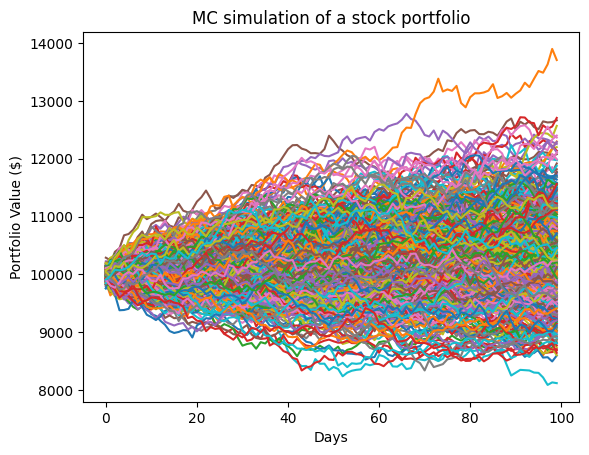

In [ ]:
# Monte Carlo Method
mc_sims = 400 # number of simulations
T = 100 #timeframe in days

meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns)
meanM = meanM.T

portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

initialPortfolio = 10000

for m in range(0, mc_sims):
  # MC loops
  Z = np.random.normal(size=(T, len(weights))) #uncorrelated RV's
  L = np.linalg.cholesky(covMatrix) #Cholesky decomposition to Lower Triangular Matrix
  dailyReturns = meanM + np.inner(L, Z) #correlated daily reutnrs for individual stocks
  portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio

plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()

In [ ]:
# Monte Carlo Simulation with value at risk (VaR) and conditional value at risk (CVaR)

def mcVaR(returns, alpha=5):
  """ Input: pandas series of returns
      Output: percentile on return distribution to a given confidence level alpha
  """
  if isinstance(returns, pd.Series):
    return np.percentile(returns, alpha)
  else:
    raise TypeError("Expected a pandas data series.")

def mcCVaR(returns, alpha=5):
  """ Input: pandas series of returns
      Output: CVaR or Expected Shortfall to a given confidence level alpha
  """
  if isinstance(returns, pd.Series):
    belowVaR = returns <= mcVaR(returns, alpha=alpha)
    return returns[belowVaR].mean()
  else:
    raise TypeError("Expected a pandas data series.")

In [ ]:
portResults = pd.Series(portfolio_sims[-1,:])

VaR = initialPortfolio - mcVaR(portResults, alpha=5)
CVaR = initialPortfolio - mcCVaR(portResults, alpha=5)

print('VaR ${}'.format(round(VaR,2)))
print('CVaR ${}'.format(round(CVaR,2)))

VaR $993.26
CVaR $1223.68
